In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from PIL import Image
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.color import gray2rgb

from tensorflow.keras.applications.vgg19 import VGG19 # VGG19
# resnet50
# vgg19
# MobileNet V2

In [2]:
tf.config.run_functions_eagerly(True)

### Load Images

In [3]:
df_bin_train = pd.read_pickle('./../data/pickle/df_bin_train.pkl')
df_bin_test = pd.read_pickle('./../data/pickle/df_bin_test.pkl')

In [4]:
df_bin_train.dropna(inplace=True)
df_bin_train.isna().value_counts()

0      1    
False  False    10243
dtype: int64

In [6]:
df_bin_train.iloc[0,0].shape # this needs to be converted to (224, 224, 3) for VGG model

(208, 176)

In [7]:
bin_train_img = df_bin_train[0].values.tolist()

In [16]:
bin_test_img = df_bin_test[0].values.tolist()

In [8]:
bin_train_img[0].shape

(208, 176)

### Image Manipulation for Transfer Learning Models
- Size
- Gray to RGB
- List to Tensor Input

In [9]:
newsize = (224,224)

In [11]:
im1 = bin_train_img[0]

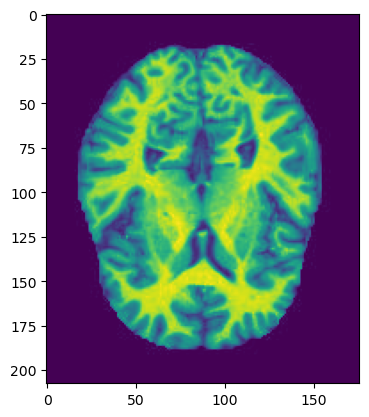

In [12]:
plt.imshow(im1)

In [13]:
# test convert image size

resized_brain1 = resize(im1, (224,224))

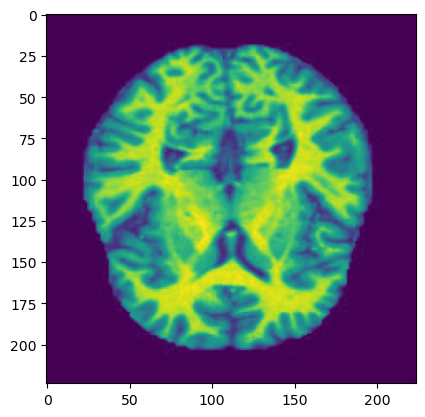

In [14]:
plt.imshow(resized_brain1)

In [17]:
#resize training img
bin_train_img = [resize(i, (224,224)) for i in bin_train_img]

#resize test img
bin_test_img = [resize(i, (224,224)) for i in bin_test_img]

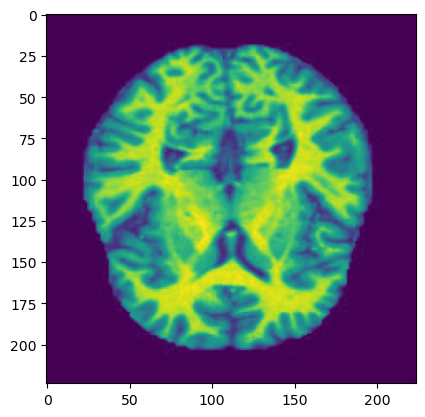

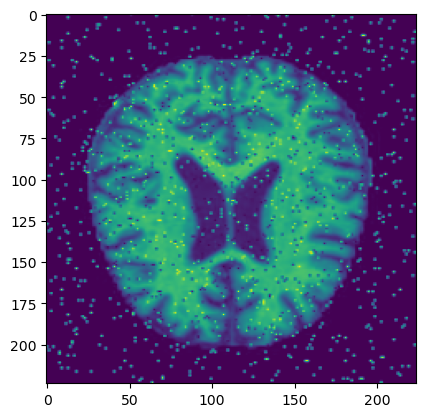

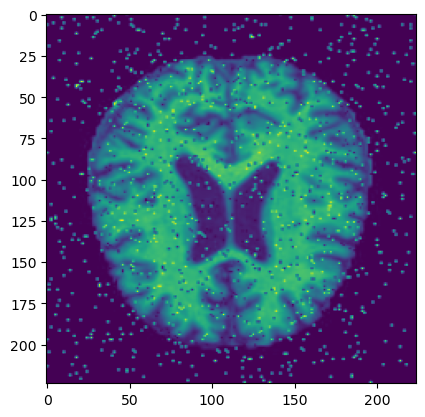

In [18]:
for i in bin_train_img[:3]:
    plt.imshow(i)
    plt.show()

In [19]:
# train to rgb
bin_train_img = [gray2rgb(i) for i in bin_train_img]

# test to rgb
bin_test_img = [gray2rgb(i) for i in bin_test_img]

In [20]:
# train to tensor
bin_train_img = tf.convert_to_tensor(bin_train_img)
print(bin_train_img.shape)

# test to tensor
bin_test_img = tf.convert_to_tensor(bin_test_img)
print(bin_test_img.shape)

2022-11-04 09:18:48.263212: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(10243, 224, 224, 3)
(1279, 224, 224, 3)


In [21]:
#train labels to list
bin_train_label = df_bin_train[1].values
print(bin_train_label.shape)

#test labels to list
bin_test_label = df_bin_test[1].values
print(bin_test_label.shape)

(10243,)
(1279,)


### VGG19

In [27]:
vgg = VGG19(input_shape=(224,224,3), weights='imagenet', include_top=False)
for layer in vgg.layers:
    layer.trainable = False
x = Flatten()(vgg.output)

prediction = Dense(1, activation='sigmoid')(x)

modelvgg = Model(inputs=vgg.input, outputs=prediction)
modelvgg.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [29]:
modelvgg.compile(optimizer='adam',
loss=tf.losses.BinaryCrossentropy(),
metrics=[keras.metrics.AUC(name='auc'),'acc'])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=8,
                                            restore_best_weights=True)

In [30]:
modelvgg.fit(bin_train_img, bin_train_label, epochs=50, validation_split=0.20, callbacks=callback)

Epoch 1/50
257/257 [==============================] - 3478s 14s/step - loss: 0.6910 - auc: 0.6304 - acc: 0.5895 - val_loss: 0.7066 - val_auc: 0.7192 - val_acc: 0.5861
Epoch 2/50
257/257 [==============================] - 3551s 14s/step - loss: 0.6257 - auc: 0.7060 - acc: 0.6373 - val_loss: 0.6182 - val_auc: 0.7426 - val_acc: 0.6374
Epoch 3/50
257/257 [==============================] - 3549s 14s/step - loss: 0.6013 - auc: 0.7328 - acc: 0.6528 - val_loss: 0.6202 - val_auc: 0.7565 - val_acc: 0.6442
Epoch 4/50
257/257 [==============================] - 3540s 14s/step - loss: 0.5740 - auc: 0.7531 - acc: 0.6628 - val_loss: 0.6549 - val_auc: 0.7699 - val_acc: 0.6364
Epoch 5/50
257/257 [==============================] - 3543s 14s/step - loss: 0.5635 - auc: 0.7675 - acc: 0.6776 - val_loss: 0.9526 - val_auc: 0.7748 - val_acc: 0.5612
Epoch 6/50
257/257 [==============================] - 3583s 14s/step - loss: 0.5518 - auc: 0.7798 - acc: 0.6868 - val_loss: 0.7063 - val_auc: 0.7704 - val_acc: 0.600

Epoch 50/50
257/257 [==============================] - 4330s 17s/step - loss: 0.3873 - auc: 0.8929 - acc: 0.7819 - val_loss: 0.5362 - val_auc: 0.8394 - val_acc: 0.7028


In [45]:
print(modelvgg.history.history.keys())

dict_keys(['loss', 'auc', 'acc', 'val_loss', 'val_auc', 'val_acc'])


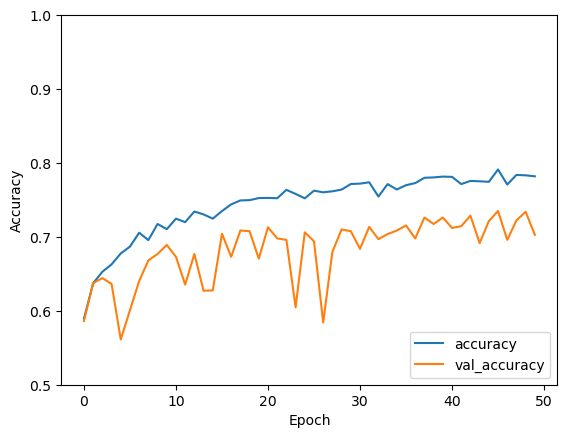

In [47]:
plt.plot(modelvgg.history.history['acc'], label='accuracy')
plt.plot(modelvgg.history.history['val_acc'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

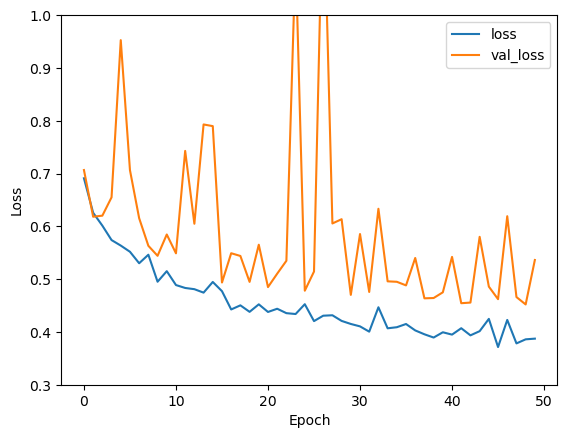

In [49]:
plt.plot(modelvgg.history.history['loss'], label='loss')
plt.plot(modelvgg.history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.3, 1])
plt.legend(loc='upper right')
plt.show()

In [79]:
plt.plot(modelvgg.history.history['auc'], label='AUC')
plt.plot(modelvgg.history.history['val_auc'], label = 'Val AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.ylim([0.3, 1])
plt.legend(loc='lower right')
plt.show()

KeyError: 'auc'

In [54]:
test_loss, test_auc, test_acc = modelvgg.evaluate(bin_test_img,  bin_test_label)

40/40 [==============================] - 215s 5s/step - loss: 0.7310 - auc: 0.8335 - acc: 0.7209


In [55]:
print(test_acc)

0.7208756804466248


### Resnet

In [56]:
resnet50 = keras.applications.ResNet50(
    weights= 'imagenet',
    input_shape= (224,224,3),
    include_top= False, pooling='avg',
    classes=2
)

In [57]:
resnet50_model = Sequential()
resnet50_model.add(resnet50)

In [58]:
resnet50_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
Total params: 23,587,712
Trainable params: 23,534,592
Non-trainable params: 53,120
_________________________________________________________________


In [59]:
resnet50_model.add(Flatten())
resnet50_model.add(Dense(512, activation='relu'))
resnet50_model.add(Dense(1, activation='sigmoid'))

In [64]:
resnet50_model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(),
              metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.AUC()])
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

In [63]:
tf.data.experimental.enable_debug_mode()

In [65]:
resnet50_model.fit(bin_train_img, bin_train_label, epochs=40, validation_split=.20, callbacks=callback)

Epoch 1/40
257/257 [==============================] - 2452s 10s/step - loss: 0.6580 - binary_accuracy: 0.5891 - auc_1: 0.6369 - val_loss: 0.6932 - val_binary_accuracy: 0.4954 - val_auc_1: 0.5000
Epoch 2/40
257/257 [==============================] - 2417s 9s/step - loss: 0.6256 - binary_accuracy: 0.6048 - auc_1: 0.6766 - val_loss: 36.6616 - val_binary_accuracy: 0.5046 - val_auc_1: 0.5000
Epoch 3/40
257/257 [==============================] - 2386s 9s/step - loss: 0.6078 - binary_accuracy: 0.6156 - auc_1: 0.6950 - val_loss: 14.7710 - val_binary_accuracy: 0.5046 - val_auc_1: 0.5010
Epoch 4/40
257/257 [==============================] - 2390s 9s/step - loss: 0.5807 - binary_accuracy: 0.6373 - auc_1: 0.7232 - val_loss: 3.9576 - val_binary_accuracy: 0.5066 - val_auc_1: 0.5211
Epoch 5/40
257/257 [==============================] - 2360s 9s/step - loss: 0.5539 - binary_accuracy: 0.6524 - auc_1: 0.7517 - val_loss: 0.5341 - val_binary_accuracy: 0.6486 - val_auc_1: 0.7589
Epoch 6/40
257/257 [=======

In [66]:
resnet50_model.history.history.keys()

dict_keys(['loss', 'binary_accuracy', 'auc_1', 'val_loss', 'val_binary_accuracy', 'val_auc_1'])

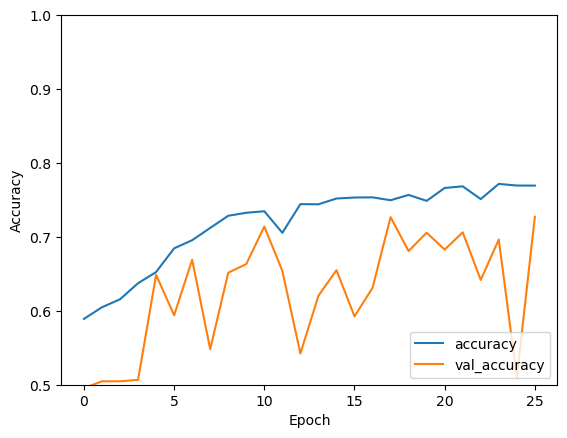

In [68]:
plt.plot(resnet50_model.history.history['binary_accuracy'], label='accuracy')
plt.plot(resnet50_model.history.history['val_binary_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

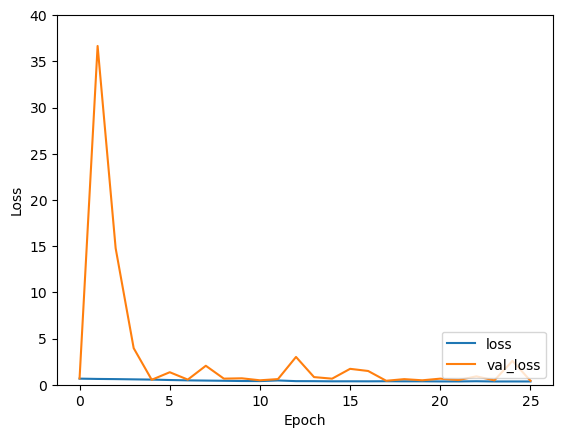

In [78]:
plt.plot(resnet50_model.history.history['loss'], label='loss')
plt.plot(resnet50_model.history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 40])
plt.legend(loc='lower right')
plt.show()

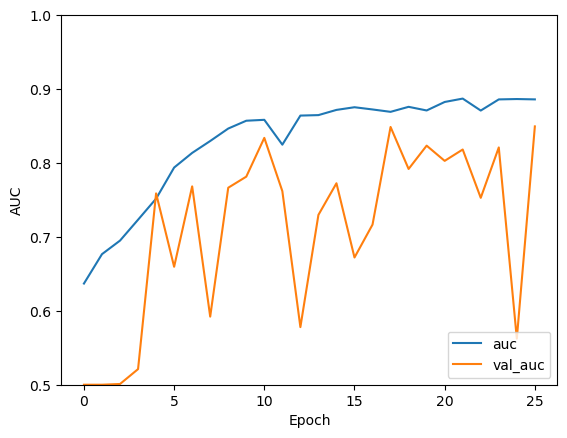

In [80]:
plt.plot(resnet50_model.history.history['auc_1'], label='auc')
plt.plot(resnet50_model.history.history['val_auc_1'], label = 'val_auc')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()